# TP1 : Apprentissage profond et traitement du signal 

## Octave Jeanne, Théo Basséras

In [761]:
from IPython.core.display import HTML
HTML("""
<style>
.consignes{
  font-weight: bold;
  color: #3256a8;
  background-color: #edebdf
}
</style>
""")



# <div class=consignes>Deep Learning et traitement du signal TP 1 </div>
<div class=consignes> L'objectif de ce TP est de prendre en main les outils de modélisation et d'analyse du signal présentés dans le premier cours et d'introduire la problématique de <it>détection</it> dont on parlera dans le cours numéro 3 </div>
<div class=consignes>Deadline de rendu : 15 octobre 2025, 13h59, par mail à deepetsignal.mva@gmail.com <br> Effort estimé : 2 à 3 heures maximum</div>
<div class=consignes>Le rendu de ce TP n'est pas obligatoire. Il permet d'obtenir un bonus de 1 (minimum syndical) à 3 (votre notebook servira de correction l'an prochain) points sur la moyenne des TP </div>

<div class=consignes> Listez les noms des étudiants (2 au maximum) ayant participé à ce notebook dans la cellule suivante (prénom, nom).<br/>
Au moment du rendu, le notebook doit être nommé nom1_nom2_dlts_tp1.ipynb </div>

<div class=consignes>Si vous installez des paquets supplémentaires, merci de les lister dans la cellule suivante avec la syntaxe
    
```
!pip install \< nom_du_paquet \>
```
    
</div>

In [762]:
import numpy as np 
import matplotlib.pylab as plt 
import scipy
import IPython.display as ipd

## <div class=consignes>Partie 1: Audio </div>

### Visualisation préliminaire

 <div class=consignes>Enregistrez un fichier wav de quelques secondes de votre voix. 
  <br>
 Importez le avec scipy.io.wavfile.read et écoutez le dans le notebook avec IPython.display.Audio
</div>

In [763]:
sampling_frequency, amplitude = scipy.io.wavfile.read(r"coloniedefourmies.wav")
ipd.Audio(  data = amplitude,
            rate = sampling_frequency)


<div class=consignes>Visualisez la forme d'onde temporelle de ce signal audio. <br>
Estimez et affichez sa Densité Spectrale de Puissance. <br>
Donnez une interprétation de ce que vous observez. 
    </div>

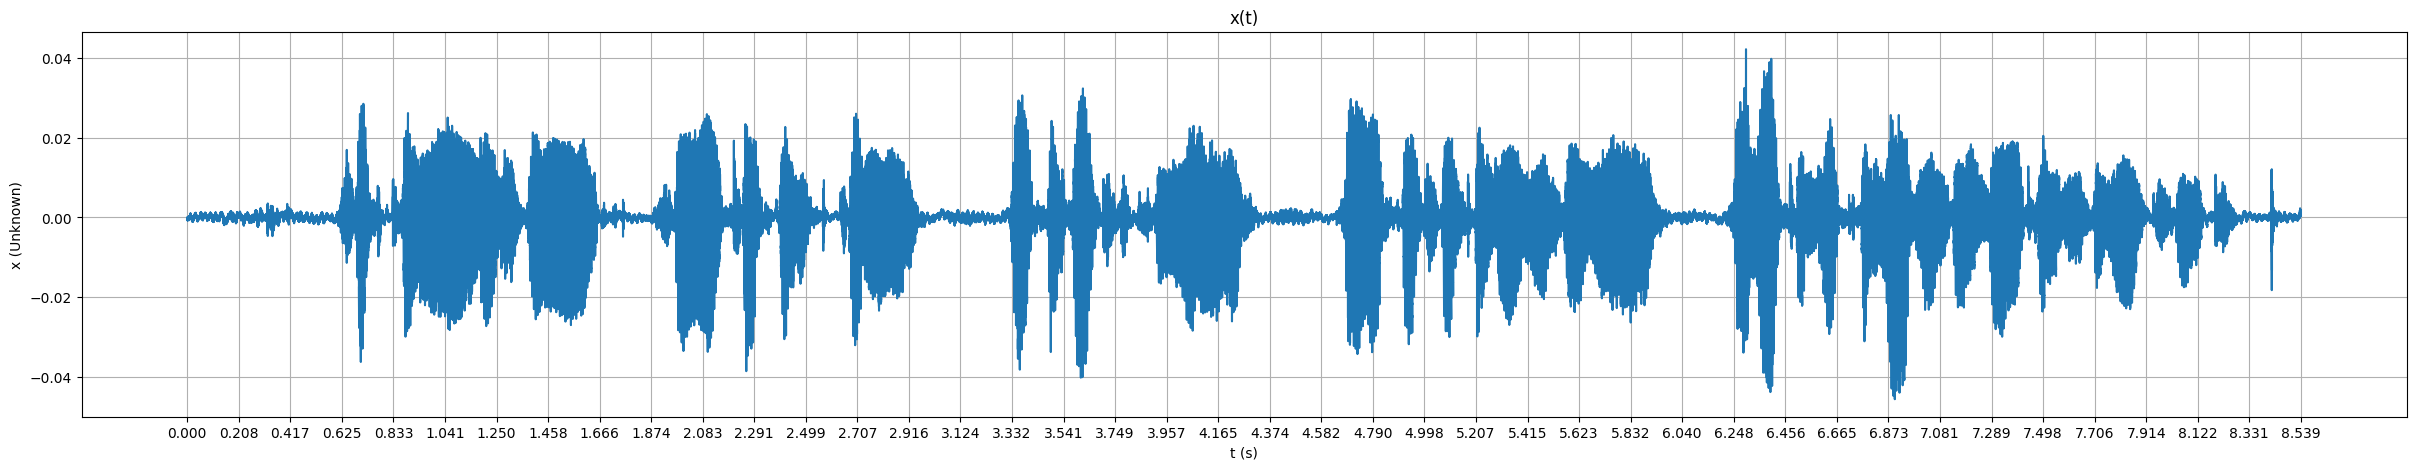

In [764]:
time = np.array([0 + i/sampling_frequency for i in range(len(amplitude))])
plt.figure(figsize = (30, 5))
plt.plot(time, amplitude)
plt.title('x(t)')
plt.xlabel('t (s)')

plt.xticks(np.linspace(start = 0, stop = time[-1], num = int(5*len(time)/(sampling_frequency))))
plt.ylabel('x (Unknown)')
plt.grid()
plt.show()

In [765]:
time[-1]

np.float64(8.539002267573697)

Le signal temporel semble présenter deux régimes de fonctionnement. L'un à haute amplitude (0.02 unité arbitraire) et l'autre à basse amplitude (pratiquement 0). Ces régimes pourrait correspondre à la présence ou à l'absence de voix.

In [766]:
def SPD(signal: np.ndarray, f_e: float) -> bool:
    
    # compute the FFT
    spectrum = np.abs(np.fft.rfft(signal))
    freqs = np.fft.rfftfreq(len(signal), d=1/f_e)

    spectral_power_density = np.abs(spectrum)**2
    
    return freqs, spectral_power_density

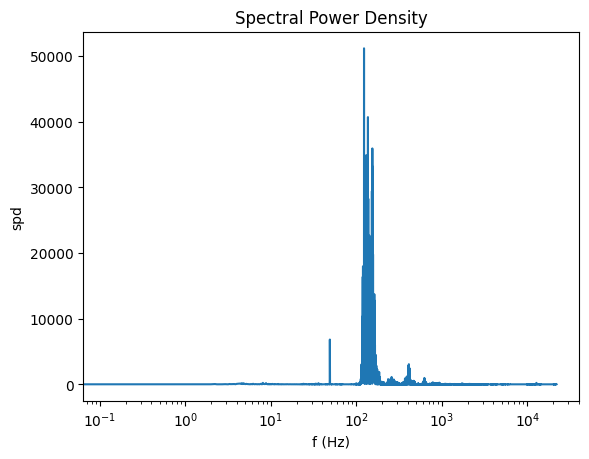

In [767]:
freqs, spectral_power_density = SPD(signal  = amplitude,
                                    f_e     = sampling_frequency)

plt.figure()
plt.plot(freqs, spectral_power_density)
plt.title('Spectral Power Density')
plt.xlabel('f (Hz)')
plt.xscale('log')
plt.ylabel('spd')
plt.show()

La distribution de densité spectrale de puissance est concentrée à basse fréquence (de l'ordre de la centaine de Hertz). 

### Visualisation du spectrogramme

<div class=consignes> Calculez et affichez le spectrogramme du signal. <br>
Justifiez du choix des réglages que vous avez faits. <br>
Sélectionnez une portion pertinente du spectrogramme pour estimer visuellement le pitch de votre voix.
    </div>

In [768]:
def compute_spectrogram(signal              :   np.ndarray,
                        window_time_size    :   float,
                        sampling_frequency  :   float)-> tuple[np.ndarray, np.ndarray, np.ndarray] :
    
    window_sample_size = sampling_frequency*window_time_size

    
    frequencies, time, short_time_fourier_transform = scipy.signal.stft(signal,
                                                                        fs = sampling_frequency,
                                                                        nperseg = window_sample_size,
                                                                        # nfft = window_sample_size,
                                                                        )
    
    # The spectrogram is defined as the squared module of the short time fourier transform
    spectrogram = np.abs(short_time_fourier_transform)**2

    return frequencies, time, spectrogram

def plot_spectrogram(signal                 :   np.ndarray,
                     window_time_size       :   float,
                     sampling_frequency     :   float,
                     log                    :   bool        =   False,
                     frequency_upper_bound  :   float       =   None) -> None:
    
    frequencies, time, spectrogram = compute_spectrogram(signal, window_time_size, sampling_frequency)

    if frequency_upper_bound is None:
        frequency_upper_bound = np.max(frequencies)

    frequencies = frequencies[frequencies<frequency_upper_bound]
    spectrogram = spectrogram[:len(frequencies),:]

    log_mes = ''
    if log:
        log_mes = 'log-'
        spectrogram = np.log10(spectrogram)

    plt.pcolor(time, frequencies, spectrogram)
    plt.title(f'{log_mes}spectrogram')
    plt.xlabel('t (s)')
    plt.ylabel('f (Hz)')
    plt.colorbar(label = f'{log_mes}value')

Choix de la taille de fenêtre : En observant le signal temporel, on voit que la plage de la plupart des zones à haute amplitude est de l'ordre de la centaine de ms. En rafinant par essais / erreur, on trouve qu'une taille de 20ms permet d'obtenir un spectrogramme dans lequel certains motifs apparaissent clairement. 

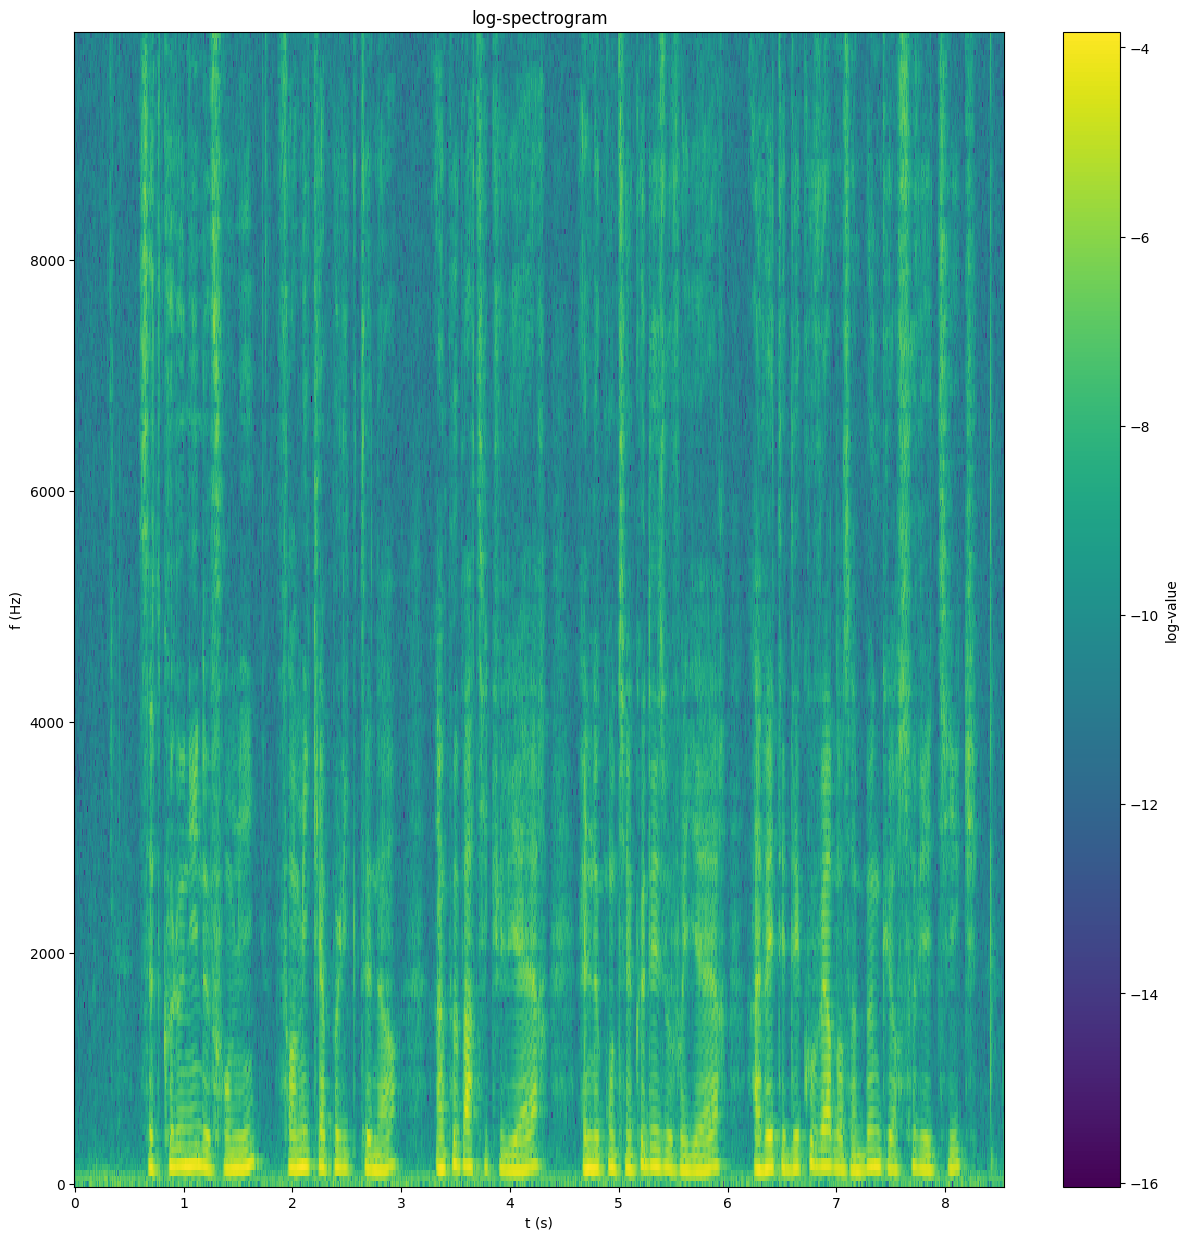

In [769]:

# Select the window size using time rather than number of points to preserve physical intuition
window_time_size = 0.02


# Unusual values above 12500 Hz (optionnal cut)
# Moreover, the human ear tends to cut frequenies above 10kHz so we know that the values above this limit are not likely to be pertinent for processing
# audible noise
frequency_upper_bound = 10000



plt.figure(figsize = (15, 15))                  # Better to have a bigger height than risk loosing info by cutting at a frequency that is too low
plot_spectrogram(signal                 =   amplitude,
                 window_time_size       =   window_time_size,
                 sampling_frequency     =   sampling_frequency,
                 log                    =   True,
                 frequency_upper_bound  =   frequency_upper_bound)

plt.show()




Visuellement, une partie du spectrogramme pertinente pour estimer le pitch de la voix dans cet enregistrement est la portion entre 6s et 8s car le pitch semble y être actif pendant une longue durée.

# Calcul du Pitch

<div class=consignes>Proposez une méthode simple pour estimer automatiquement le Pitch de votre voix (cette méthode ne doit pas faire intervenir d'implémentations externes).

Utilisez cette méthode pour estimer les variations du Pitch le long du signal, estimez le pitch toutes les 20 ms et présentez vos résultats sous forme visuelle. 

Ne pas utiliser de méthode "toute faite" que vous pourriez par exemple trouver dans la bibliothèque librosa.

Commentez vos résultats.
    </div>

Avant d'implémenter une méthode, on réalise des tests prémiminaires.

D'abord, on cherche à mettre en évidence les potentiels pitch en sélectionnant les fréquences portants le plus de densité spectrale de puissance à chaque instant.

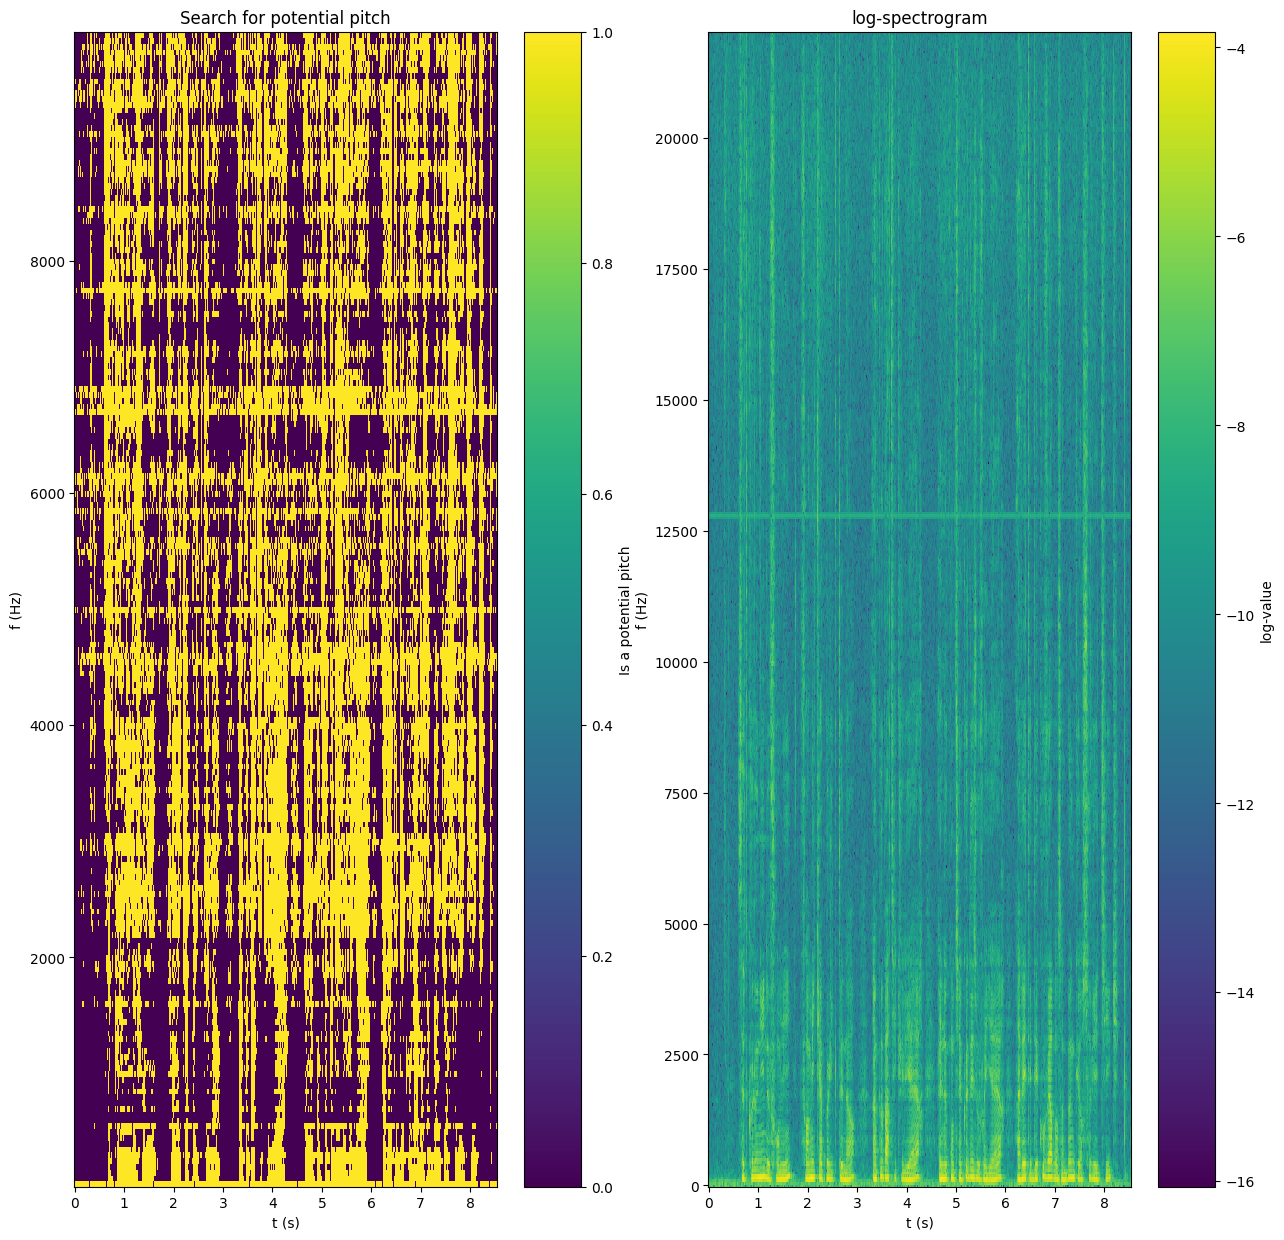

In [770]:
# Test : the pitch is supposed to cary the most power
# -> Does not work in practice ( due to unusual values from the mean of measure ??)
# May be usefull to check for harmonic first and then get the harmonic that carries the most power (i.e the lowest one)


# compute the log-spectrogram
frequencies, time, spectrogram = compute_spectrogram(signal=amplitude,
                                                     window_time_size=window_time_size,
                                                     sampling_frequency=sampling_frequency)

frequency_lower_bound = 1
frequency_upper_bound = 10000

# Filter the 
N = len(frequencies)
frequencies = frequencies[(frequency_lower_bound<frequencies)]
spectrogram = spectrogram[N - len(frequencies):,:]
frequencies = frequencies[(frequencies<frequency_upper_bound)]
spectrogram = spectrogram[:len(frequencies),:]


log_spectrogram = np.log10(spectrogram)

# Get the max spd at each time_steps
tolerance = 0.5
max_log_DSP_windowize = np.max(log_spectrogram,
                               axis = 1)
max_log_DSP_windowize = np.transpose(np.array([max_log_DSP_windowize for i in range(log_spectrogram.shape[1])]))

# Get all the potential pitch at each time steps 
# The pitch is supposed to carry some significant power so it is likely that it has a power that is near the max
frequency_in_max_spd = log_spectrogram.copy()
frequency_in_max_spd[frequency_in_max_spd<(max_log_DSP_windowize + tolerance*max_log_DSP_windowize)]     = 0
frequency_in_max_spd[~(frequency_in_max_spd==0)]  = 1


plt.figure(figsize = (15, 15))                  # Better to have a bigger height than risk loosing info by cutting at a frequency that is too low
plt.subplot(121)
plt.pcolor(time, frequencies, frequency_in_max_spd)
plt.title('Search for potential pitch')
plt.xlabel('t (s)')
plt.ylabel('f (Hz)')
plt.colorbar(label = 'Is a potential pitch')
plt.subplot(122)
plot_spectrogram(signal             =   amplitude,
                 window_time_size   =   window_time_size,
                 sampling_frequency =   sampling_frequency,
                 log                =   True)
plt.show()

Le test précédent montre que le motif associé au pitch (autour de 100Hz) est bien sélectionné parmis les pitchs potentiels. Cependant, la plupart des hautes fréquences sont égalements sélectionnées. 

Une autre idée est que la personne parle pendant une partie significative de l'enregistrement. De fait le pitch est cencé porter une importante densité spectrale de puissance dans de nombreuses fenêtres. De fait, pour chaque fréquence, on définit son taux d'activation comme la somme des densités spectrales de puissance qu'elle porte à chaque instant dans le spectrogramme.

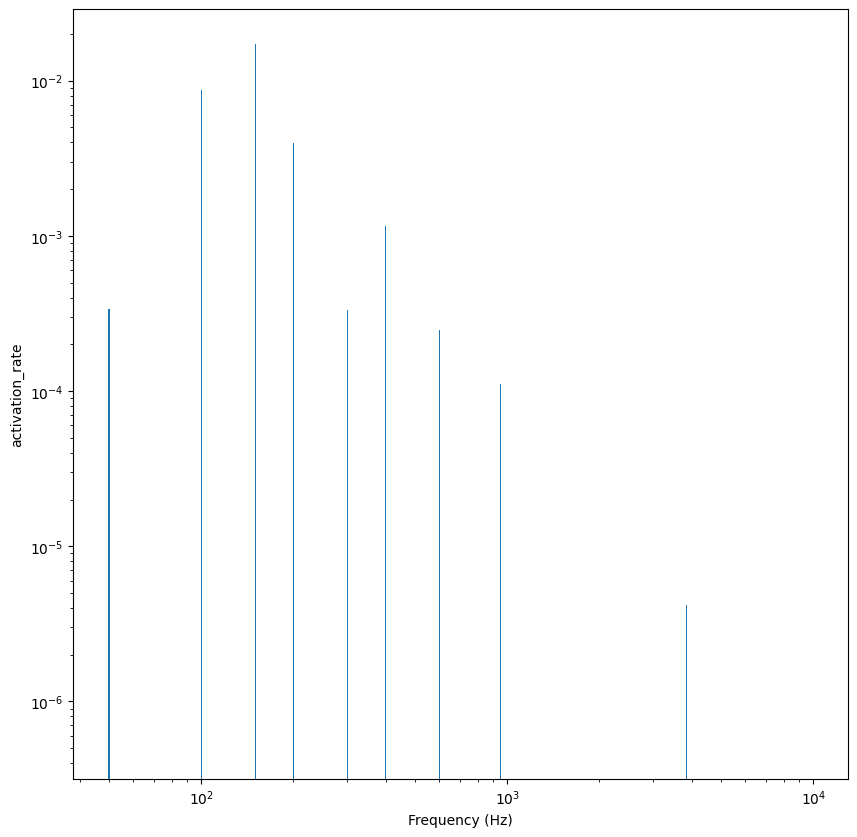

In [771]:
# Idea : The person is speaking through most of the audio and its pitch is not supposed to change overtime
# Thus the pitch has to "active" (i.e in the max of the spd) at most time steps
# However there is too much noise so a brutal count won't do the trick
# To compensate we use a ponderation based on the spd value (if it has some high power than it should count more)

# We will call the weighted count the "activation rate"

activation_rate = np.zeros(len(frequencies))

for time_step in range(len(time)):
    # activation_rate += frequency_in_max_spd[:,time_step] * spectrogram[:,time_step]
    activation_rate += spectrogram[:,time_step]

plt.figure(figsize=(10,10))
plt.bar(frequencies, activation_rate, width=0.8, align='center')
plt.xlabel("Frequency (Hz)")
plt.ylabel("activation_rate")
plt.xscale('log')
plt.yscale('log')                       # Set the scale to log to emphasize contrast
plt.show()

L'histogramme du taux d'activation définit précédemment indique que la fréquence la plus active est de l'ordre de la centaine de Hertz. Cette ordre de grandeur est cohérent avec le motif que l'on peut voir sur le spectrogramme.

On en déduis que le pitch peut être estimé comme la fréquence dont le taux d'activation est le plus élevé.

In [772]:
pitch_index = list(activation_rate).index(max(activation_rate))
pitch = frequencies[pitch_index]
pitch

np.float64(150.0)

# Partie 2: Détection d'impulsion 

<div class=consignes> Un signal de durée 1 seconde et échantillonné à 1000 Hz est composé d'un bruit blanc gaussien de puissance inconnue et éventuellement d'une impulsion à une fréquence f0 comprise entre 100 et 200 Hz. 
<br><br>
Une série de 1000 signaux est enregistrée dans le fichier signaux_impulsions.npz. 
Ouvez ce fichier avec numpy (cf code plus bas). Le fichier contient une tableau signaux 10000 x 1000 dont chaque ligne contient un signal de durée 1000. Le fichiez contient aussi un tableau labels de taille 10000 dont la ligne i est à TRUE si le signal i contient une impulsion et à 0 sinon. 

</div>

In [773]:
donnees = np.load('signaux_impulsions.npz')
signaux = donnees['data']
labels = donnees['labels']


## Première méthode

<div class=consignes> Proposez une méthode simple  pour décider si un signal contient une impulsion ou non à partir du calcul de l'énergie du signal. Cette méthode fera intervenir un seuil: 
</div>

```python
def contient_impulsion_energie(signal: np.ndarray, seuil: float) -> bool:
```

On suppose que notre signal contient une impulsion (de l'information) s'il est assez puissant, en d'autres termes si son énergie est supérieure à un certain seuil.

In [774]:
def contient_impulsion_energie(signal: np.ndarray, seuil: float) -> bool:
    # Calcul de l’énergie du signal
    energie = np.sum(signal.astype(float)**2)
    
    # Comparaison au seuil
    return energie > seuil

<div class=consignes>
Utilisez votre méthode avec un seuil fixé sur tous les signaux pour prédire s'ils contiennent une impulsion ou non. 
</div>

Le seuil est choisit comme une pondération de l'énergie moyenne des signaux de la base de données. Le poids de la pondération sera un hyperparamètre à bien choisir.

In [775]:

weight = 0.6
avg_energy = weight*np.sum(signaux**2)/len(signaux)


estimated_labels=[]
for k in range (len(signaux)):
    estimated_labels.append(bool(contient_impulsion_energie(signal = signaux[k,:], 
                                                            seuil  = avg_energy)))
estimated_labels = np.array(estimated_labels).astype(int)

accuracy = np.sum((labels == estimated_labels).astype(int))


<div class=consignes>
Calculez: <br>
- VP = le nombre de signaux que vous détectez comme contenant une impulsion qui contiennet effectivement une impulsion <br>
- FP = le nombre de signaux que vous détectez comme contenant une impulsion qui ne contiennet en fait PAS une impulsion <br>
- VN = le nombre de signaux que vous détectez comme ne contenant PAS une impulsion qui ne contiennet effectivement PAS une impulsion<br>
- FN = le nombre de signaux que vous détectez comme ne contenant PAS une impulsion mais qui  contiennet en fait une impulsion
</div>

In [776]:
def get_VP_FP_VN_FN(estimated_labels, labels):
    difference=estimated_labels-labels
    VP=0
    FP=0
    VN=0
    FN=0

    for k in range(len(estimated_labels)):
        if difference[k]>0:
            FP+=1
        elif difference[k]==0 and estimated_labels[k]==1:
            VP+=1
        if difference[k]<0:
            FN+=1
        elif difference[k]==0 and estimated_labels[k]==0:
            VN+=1
    
    return VP, FP, VN, FN

In [777]:
VP, FP, VN, FN = get_VP_FP_VN_FN(estimated_labels, labels)

print("VP=",VP,", FP=",FP,", VN=",VN,", FN=",FN)
    


VP= 4031 , FP= 2718 , VN= 2278 , FN= 973


## Deuxième méthode

<div class=consignes>Proposez une deuxième méthode faisant par exemple intervenir le spectrogramme du signal. Cette méthode fera encore intervenir un seuil
</div>

```python
def contient_impulsion_spectrogramme(signal: np.ndarray, seuil: float) -> bool:
```


La consigne indique de se baser sur l'allure du spectrogramme. Avant d'élaborer une méthode, on compare le spectrogramme d'un signal avec impulsion avec celui d'un signal sans imulsion.

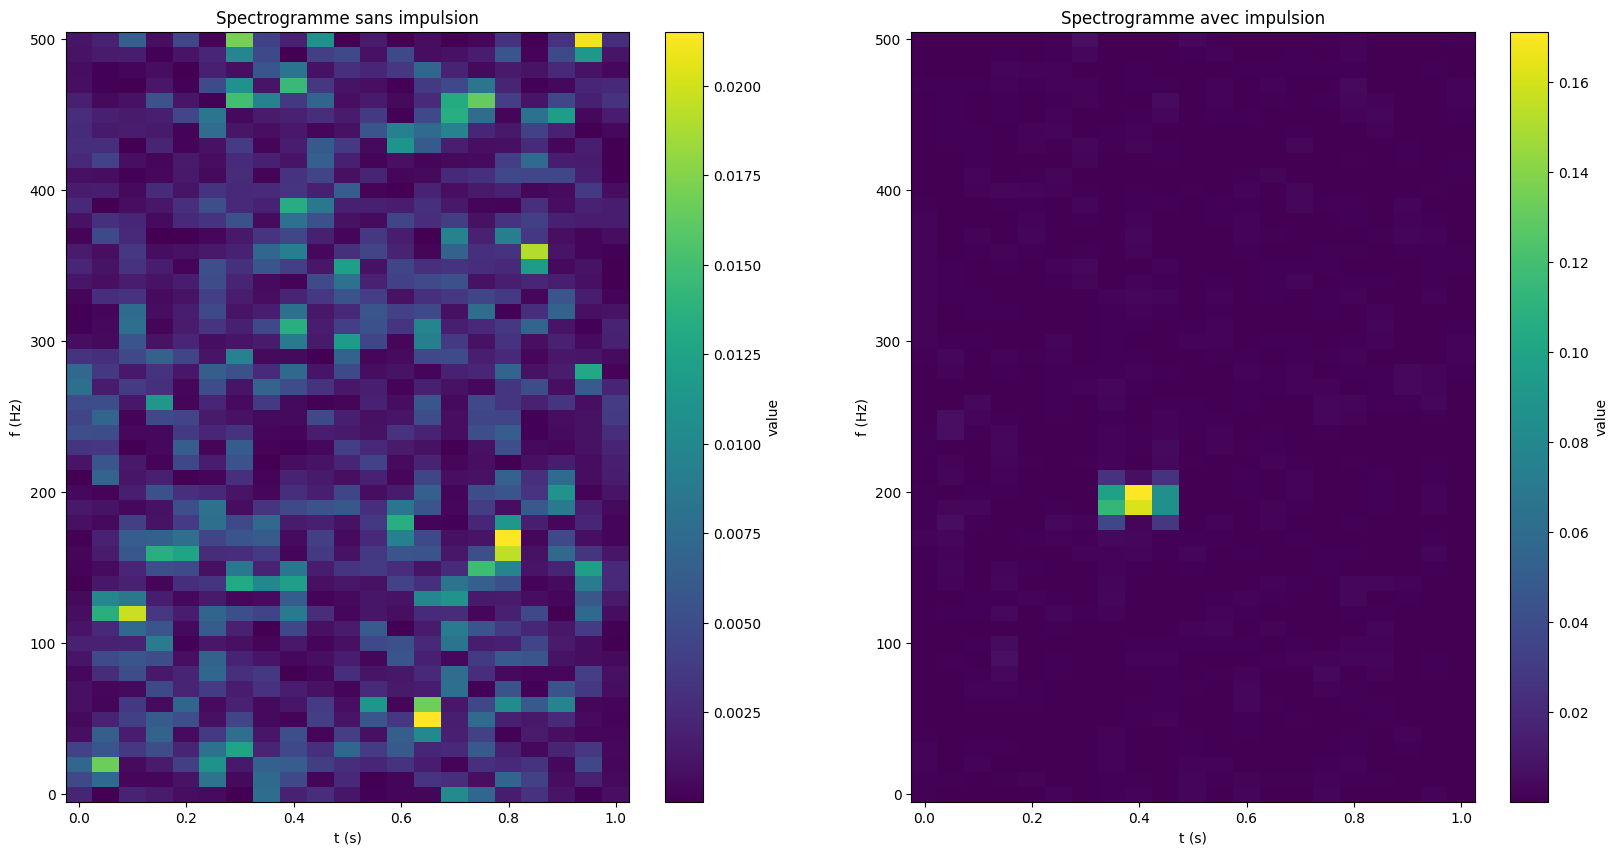

In [778]:




    

# Select the window size using time rather than number of points to preserve physical intuition
window_time_size = 0.1

signal_0 = signaux[0,:]


signal_1 = signaux[-1,:]

plt.figure(figsize=(20, 10))
plt.subplot(121)
plot_spectrogram(signal_0, window_time_size, log = False, frequency_upper_bound =   10000, sampling_frequency=1000)
plt.title('Spectrogramme sans impulsion')
plt.subplot(122)
plot_spectrogram(signal_1, window_time_size, log = False, frequency_upper_bound =   10000, sampling_frequency=1000)
plt.title('Spectrogramme avec impulsion')
plt.show()





Le spectrogramme d'un signal sans impulsion est relativement homogène, ce qui est cohérent étant donné que l'on observe un bruit blanc gaussien.

Le spectrogramme d'un signal avec impulsion présente un pic d'amplitude à une certaine fréquence et à un certain instant. Ici le pic est observé pour une fréquence d'environ 200Hz à 0.4s après le début de l'enregistrement. L'ordre de grandeurs de la fréquence à ce pic est cohérent avec la description de la base de données (perturbation avec une impulsion d'une centaine de Hz)

Cependant, on partira du principe que la fréquence de l'impulsion perturbatrice et l'amplitude du bruit blanc gaussien sont amenés à changer. Dans cette mesure, l'impulsion est mise en évidence par la présence d'un pic dans le spectre à un certain instant. De fait, on s'attend à ce que l'énergie présente dans la fenêtre contenant l'impusion soit "nettement" supérieure à l'énergie moyenne présente dans chaque fenêtre. 

Ici "nettement supérieure à l'énergie moyenne" signifie supérieure à l'énergie moyenne pondérée par une valeur à choisir. Cette énergie moyenne pondérée définit donc un seuil de détection.

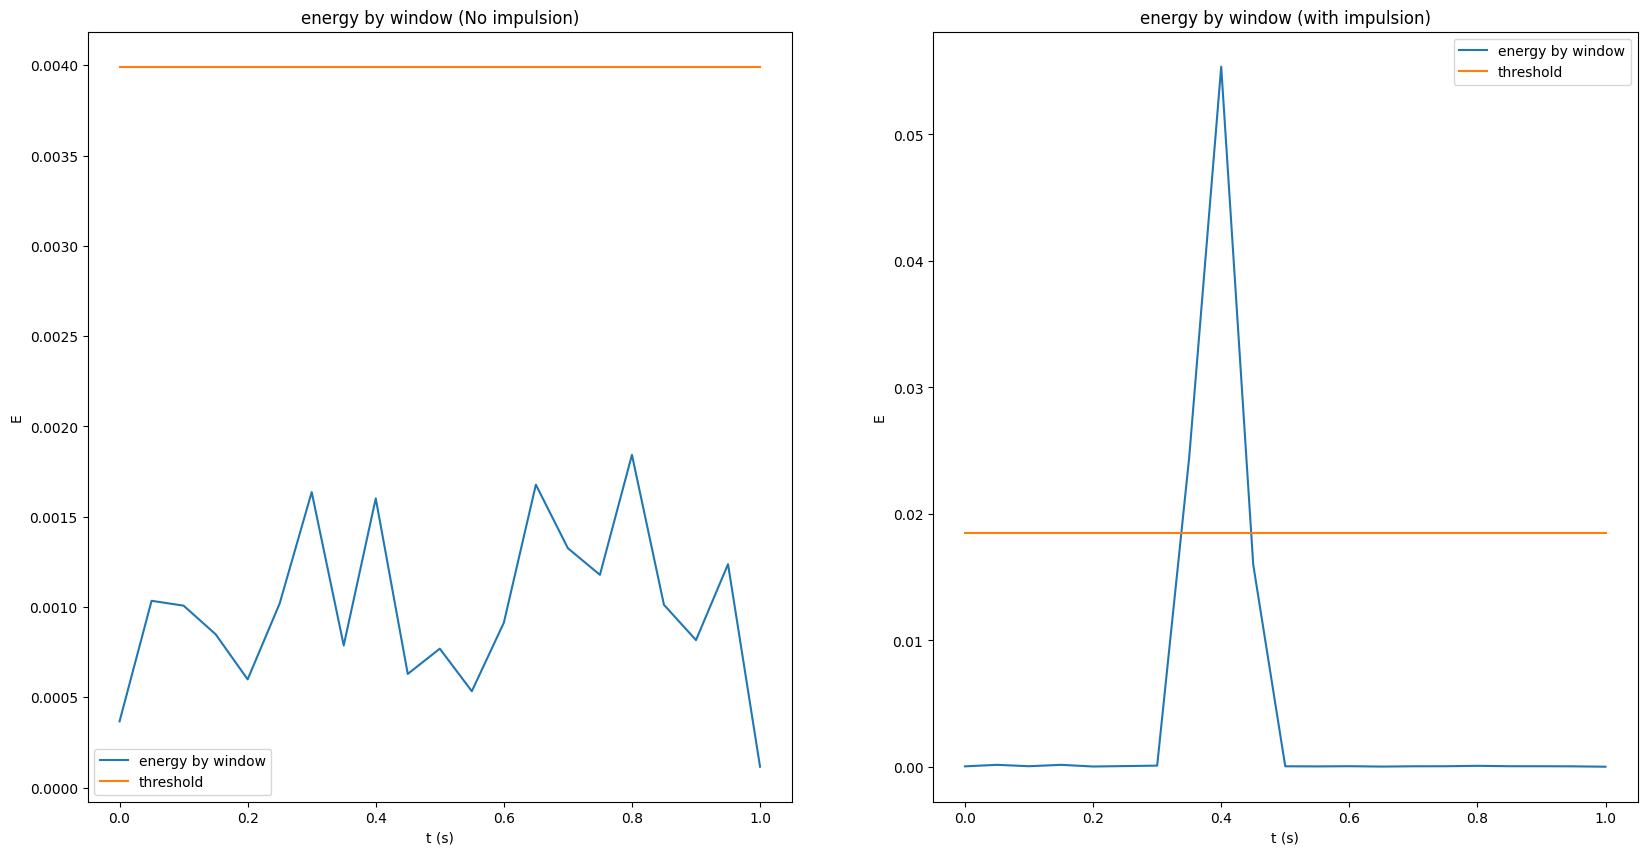

In [779]:
threshold_weight = 4

frequencies_0, time_0, spectrogram_0  = compute_spectrogram(signal_0, window_time_size, sampling_frequency = 1000)
energy_by_window_0 = np.sum(spectrogram_0**2, axis = 0)
threshold_0 = threshold_weight*np.sum(energy_by_window_0)/len(energy_by_window_0)

frequencies_1, time_1, spectrogram_1  = compute_spectrogram(signal_1, window_time_size, sampling_frequency = 1000)
energy_by_window_1 = np.sum(spectrogram_1**2, axis = 0)
threshold_1 = threshold_weight*np.sum(energy_by_window_1)/len(energy_by_window_1)


plt.figure(figsize= (20, 10))
plt.subplot(121)
plt.plot(time_0, energy_by_window_0)
plt.plot(time_0, [threshold_0 for _ in time_0])
plt.legend(['energy by window', 'threshold'])
plt.title('energy by window (No impulsion)')
plt.xlabel('t (s)')
plt.ylabel('E')
plt.subplot(122)
plt.plot(time_1, energy_by_window_1)
plt.plot(time_1, [threshold_1 for _ in time_1])
plt.legend(['energy by window', 'threshold'])
plt.title('energy by window (with impulsion)')
plt.xlabel('t (s)')
plt.ylabel('E')
plt.show()



Les observations ci-dessus confirment que comparer l'énergie dans chaque fenêtre au seuil basé sur l'énergie moyenne par fenêtre pondérée par un paramètre à le potentiel de fournir une méthode de détection pertinente. 

La méthode de détection proposée sera donc la suivante :
- Calculer le spectrogramme et l'énergie moyenne par fenêtre.
- Comparer l'énergie de chaque fenêtre à l'énergie moyenne pondérée par un poids à choisir
- Si une fenêtre présente plus d'énergie que la moyenne pondérée alors la méthode renvoie qu'une impulsion est présente.

In [780]:

def contient_impulsion_spectrogramme_2(signal               : np.ndarray,
                                       window_time_size     : float,
                                       sampling_frequency   : float,
                                       threshold_weight     : float)      -> bool :      
    
    frequencies, time, spectrogram  = compute_spectrogram(signal, window_time_size, sampling_frequency)
    energy_by_window = np.sum(spectrogram**2, axis = 0)
    threshold = threshold_weight*np.sum(energy_by_window)/len(energy_by_window)

    contains_impulsion = np.sum((energy_by_window>threshold).astype(int))>0
    
    return contains_impulsion

In [781]:
signal_0_contains_impulsion = contient_impulsion_spectrogramme_2(signal               =   signal_0,
                                                                 sampling_frequency   =   sampling_frequency,
                                                                 window_time_size     =   window_time_size,
                                                                 threshold_weight     =   5)

signal_1_contains_impulsion = contient_impulsion_spectrogramme_2(signal               =   signal_1,
                                                                 sampling_frequency   =   sampling_frequency,
                                                                 window_time_size     =   window_time_size,
                                                                 threshold_weight     =   5)

print(f'signal_0_contains_impulsion\t:\t{signal_0_contains_impulsion}')
print(f'signal_1_contains_impulsion\t:\t{signal_1_contains_impulsion}')

signal_0_contains_impulsion	:	False
signal_1_contains_impulsion	:	False


C:\Users\octav\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\signal\_spectral_py.py:1240: UserWarning: nperseg = 4410 is greater than input length  = 1000, using nperseg = 1000
  freqs, time, Zxx = _spectral_helper(x, x, fs, window, nperseg, noverlap,


<div class=consignes> Calculez pour cette nouvelle méthode, pour un certain seuil les valeurs de VP, FP, VN, FN </div>

In [782]:
sampling_frequency = 1000
window_time_size   = 0.001
threshold_weight   = 4

estimated_labels = []
for signal in signaux:
    signal_contains_impulsion = contient_impulsion_spectrogramme_2(signal               =   signal,
                                                                   sampling_frequency   =   sampling_frequency,
                                                                   window_time_size     =   window_time_size,
                                                                   threshold_weight     =   threshold_weight)
    estimated_labels.append(signal_contains_impulsion)

estimated_labels = np.array(estimated_labels).astype(int)


VP, FP, VN, FN = get_VP_FP_VN_FN(estimated_labels, labels)


print("VP=",VP,", FP=",FP,", VN=",VN,", FN=",FN)




VP= 5004 , FP= 4996 , VN= 0 , FN= 0


## Comparaison des méthodes

Pour une méthode de détection et un seuil donné, la précision est définie comme: 
$$ \frac{\text{Signaux détectés comme contenant une impulsion qui en contiennent effectivement une}}{\text{Signaux détectés comme positifs }}$$
et le rappel comme:
$$ \frac{\text{Signaux détectés comme contenant une impulsion qui en contiennent effectivement une}}{ \text{Signaux contenant une impulsions}} $$
    


<div class=consignes> Donnez une interprétation de ces deux métriques </div>

La première métrique permet de savoir sur les signaux détecté quel pourcentage est correct. Par exemple si on détecte 100 impulsions alors uniquement rappel*100 sera le nombre de véritable impulsion parmi celle détecté ou encore si on sélectionne une impulsion parmi les 100 détectés  alors sa probabilité d'être une véritable impulsion est précision.


La seconde métrique permet d'avoir une idée de combien de signaux sont détectés par rapport au nombre de signaux total. En d'autres estime le pourcentage de signaux qu'on a manqué, qu'on n'a pas détecté. En d'autres termes, si notre a 100 impulsions si on choisit une impulsion parmi celles ci la probabilité qu'elle soit détectée est rappel.



<div class=consignes>
    Pour chacune des deux méthodes proposées, faites varier le seuil sur une dizaine de valeurs et calculez la précision et le rappel pour chacun de ces seuils. 

Affichez dans le plan (précision , rappel) les points de fonctionnement des deux méthodes pour différents seuils. <br>Commentez le résultat. 
    </div>

In [783]:
def get_precision_rappel(estimated_labels, labels):
    VP, FP, VN, FN = get_VP_FP_VN_FN(estimated_labels, labels)
    if VP + FP == 0:
        precision = -1
    else:
        precision = VP/(VP+FP)
    rappel = VP/(np.sum(labels))

    return precision, rappel


step	:	0/10
step	:	1/10
step	:	2/10
step	:	3/10
step	:	4/10
step	:	5/10
step	:	6/10
step	:	7/10
step	:	8/10
step	:	9/10


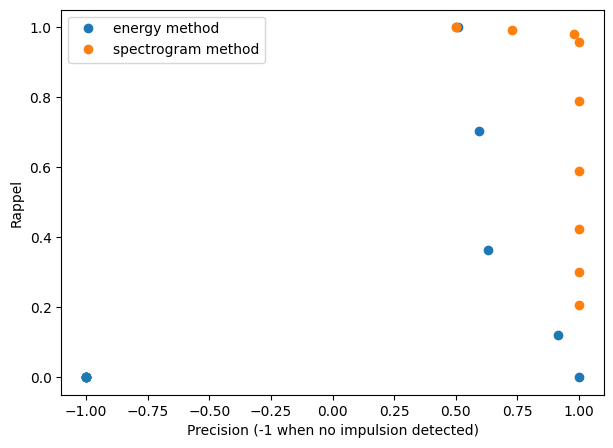

In [784]:
sampling_frequency = 1000
window_time_size  = 0.1

N = 10

energy_thresholds = np.linspace(0.1* avg_energy,10* avg_energy,N)

spectrogram_thresholds = np.linspace(start = 0, stop = 10, num = N)

energy_precisions       = []
energy_rappels          = []
spectrogram_precisions  = []
spectrogram_rappels     = []

for i in range(N):
    print(f'step\t:\t{i}/{N}')
    energy_estimated_labels      = []
    spectrogram_estimated_labels = []

    for signal in signaux:
        energy_estimated_labels.append(contient_impulsion_energie(signal, energy_thresholds[i]))
        spectrogram_estimated_labels.append(contient_impulsion_spectrogramme_2(signal               =   signal,
                                                                               sampling_frequency   =   sampling_frequency,
                                                                               window_time_size     =   window_time_size,
                                                                               threshold_weight     =   spectrogram_thresholds[i]))
    
    energy_estimated_labels         = np.array(energy_estimated_labels).astype(int)
    spectrogram_estimated_labels    = np.array(spectrogram_estimated_labels).astype(int)

    energy_precision, energy_rappel             = get_precision_rappel(energy_estimated_labels, labels)
    energy_precisions.append(energy_precision)
    energy_rappels.append(energy_rappel)

    spectrogram_precision, spectrogram_rappel   = get_precision_rappel(spectrogram_estimated_labels, labels)
    spectrogram_precisions.append(spectrogram_precision)
    spectrogram_rappels.append(spectrogram_rappel)

plt.figure(figsize=(7,5))
plt.plot(energy_precisions, energy_rappels, 'o')
plt.plot(spectrogram_precisions, spectrogram_rappels, 'o')
plt.legend(['energy method', 'spectrogram method'])
plt.xlabel('Precision (-1 when no impulsion detected)')
plt.ylabel('Rappel')
plt.show()












On observe que l'on est plus précis en utilisant la méthode du spectrogramme que pour la méthode de l'énergie (à rappel fixé on a une précision plus grande pour la méthode utilisant le spectrogramme que pour la méthode utilisant l'energie).




Remarques:
 
1. Les points 0 pour la courbe de l'énergie est due au fait qu'à partir d'un seuil trop grand on n'accepte plus aucun signal.

2. On remarque que le rappel=1 est atteint au même niveau pour chacun des deux signaux, en effet c'est le cas où le seuil est très bas donc on accepte tous les signaux, de ce fait puisque le rappel = P(probabilité d'accepter un signal et ce signal est une impulsion)>=P(probabilité d'accepter un signal)=1 (dans le cas où le seuil est très faible)


3. La méthode du spectrogramme présente un seuil pour lequel le compromis entre précision et rappel est quasi-parfait (pratiquement (1;1) sur la courbe précision/rappel)